In [1]:
from sentence_transformers import SentenceTransformer, util

# Load model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight and fast

In [49]:
# environment/LLM/rule_based_citation_rater.py

import re
from sentence_transformers import SentenceTransformer, util
from abc import ABC, abstractmethod

class Rater(ABC):
    def __init__(self, llm=None, current_items_features_list=None, previous_items_features_list=None, llm_render=False, llm_query_explanation=False):
        self.llm = llm
        self.llm_render = llm_render
        self.llm_query_explanation = llm_query_explanation
        self.current_items_features_list = current_items_features_list if current_items_features_list else []
        self.previous_items_features_list = previous_items_features_list if previous_items_features_list else []

    @abstractmethod
    def query(self, user, item, num_interacted, interactions, retrieved_items):
        pass

class RuleBasedCitationRater(Rater):
    def __init__(self, 
                 bert_model=None, 
                 weight_topic=0.6, 
                 weight_novelty=0.15, 
                 weight_reputability=0.15):
        """
        Rule-Based Citation Rater.
        """
        super().__init__(llm=None)
        
        if bert_model is None:
            self.bert_model = SentenceTransformer('all-MiniLM-L6-v2')  # default lightweight model
        else:
            self.bert_model = bert_model

        self.weight_topic = weight_topic
        self.weight_novelty = weight_novelty
        self.weight_reputability = weight_reputability

    def parse_user_preferences(self, user):
        """
        Parse novelty and reputability preferences from user description.
        """
        description = user.description

        novelty_match = re.search(r'Prefers novelty: ([0-9.]+)', description)
        reputability_match = re.search(r'reputability bias: ([0-9.]+)', description)
        
        

        novelty = float(novelty_match.group(1)) if novelty_match else 0.5
        reputability = float(reputability_match.group(1)) if reputability_match else 0.5

        return novelty, reputability

    def compute_semantic_topic_score(self, user, item):
        """
        Compute cosine similarity between user interests and paper (title + topics).
        """
        user_text = user.description.split("Prefers novelty")[0]  # just interested in: ...
        paper_text = item.title + " " + " ".join(item.topics)


        # Encode
        user_emb = self.bert_model.encode(user_text, convert_to_tensor=True)
        paper_emb = self.bert_model.encode(paper_text, convert_to_tensor=True)

        # Cosine similarity
        similarity = util.cos_sim(user_emb, paper_emb).item()
        similarity = max(0, similarity)  # Clamp to [0,1]


        return similarity

    def compute_novelty_score(self, novelty_pref, item):
        """
        Higher score if normalized year matches user's novelty preference.
        """
        return 1.0 - abs(novelty_pref - item.norm_year)

    def compute_reputability_score(self, reputability_bias, item):
        """
        Higher score if normalized citations match user's reputability bias.
        """
        return 1.0 - abs(reputability_bias - item.norm_cite)

    def query(self, user, item, num_interacted=None, interactions=None, retrieved_items=None):
        """
        Query rating function — must match (rating, explanation, prompt).
        """
        novelty_pref, reputability_bias = self.parse_user_preferences(user)

        topic_score = self.compute_semantic_topic_score(user, item)
        novelty_score = self.compute_novelty_score(novelty_pref, item)
        reputability_score = self.compute_reputability_score(reputability_bias, item)
        # print(f"Topic score: {topic_score}, Novelty score: {novelty_score}, Reputability score: {reputability_score}")
        final_score = (
            self.weight_topic * topic_score +
            self.weight_novelty * novelty_score +
            self.weight_reputability * reputability_score
        )

        rating = round(final_score * 9)
        rating = min(9, max(0, rating))  # Clamp

        # We return rating, empty explanation, empty prompt (for compatibility)
        return rating, "", ""


In [50]:
users_loader.get_users()[0].description

'Interested in: Web visibility and informetrics. Prefers novelty: 0.74, reputability bias: 0.47'

In [51]:
import random
import pandas as pd
from environment.users.user import User
from environment.citations.citation import Citation


rater = RuleBasedCitationRater(
)
# --------------------------------------------
# Create the user
# --------------------------------------------
example_user = users_loader.get_users()[0]

# No need to manually add novelty_preference and reputability_bias manually!
# Now it will be automatically parsed from description text.

# --------------------------------------------
# Create two synthetic papers
# --------------------------------------------

# ✅ Relevant paper
relevant_paper = Citation(
    id=1000,
    title="Advances in Web Visibility and Informetrics Techniques",
    year=2022,
    topics=["Web visibility and informetrics", "Scientometrics"],
    topic_scores=[0.98, 0.95],
    cited_by_count=2500,
    norm_cite=0.9,
    norm_year=0.98
)

# ❌ Irrelevant paper
irrelevant_paper = Citation(
    id=1001,
    title="Crop Rotation Strategies in Agricultural Sciences",
    year=2010,
    topics=["Agricultural Sciences", "Crop Management"],
    topic_scores=[0.7, 0.65],
    cited_by_count=120,
    norm_cite=0.2,
    norm_year=0.6
)

# --------------------------------------------
# Query rule-based rater
# --------------------------------------------

rating_relevant, _, _ = rater.query(example_user, relevant_paper, 0, [], [])
rating_irrelevant, _, _ = rater.query(example_user, irrelevant_paper, 0, [], [])

# --------------------------------------------
# Display results
# --------------------------------------------
print("🧑‍💼 User Profile:")
print(f"  Description: {example_user.description}")

print("\n✅ Relevant Paper:")
print(f"  Title: {relevant_paper.title}")
print(f"  Topics: {relevant_paper.topics}")
print(f"  Norm Year: {relevant_paper.norm_year}")
print(f"  Norm Citations: {relevant_paper.norm_cite}")

print(f"\n🎯 Predicted Rating for Relevant Paper: {rating_relevant}")

print("\n❌ Irrelevant Paper:")
print(f"  Title: {irrelevant_paper.title}")
print(f"  Topics: {irrelevant_paper.topics}")
print(f"  Norm Year: {irrelevant_paper.norm_year}")
print(f"  Norm Citations: {irrelevant_paper.norm_cite}")

print(f"\n🚫 Predicted Rating for Irrelevant Paper: {rating_irrelevant}")


🧑‍💼 User Profile:
  Description: Interested in: Web visibility and informetrics. Prefers novelty: 0.74, reputability bias: 0.47

✅ Relevant Paper:
  Title: Advances in Web Visibility and Informetrics Techniques
  Topics: ['Web visibility and informetrics', 'Scientometrics']
  Norm Year: 0.98
  Norm Citations: 0.9

🎯 Predicted Rating for Relevant Paper: 6

❌ Irrelevant Paper:
  Title: Crop Rotation Strategies in Agricultural Sciences
  Topics: ['Agricultural Sciences', 'Crop Management']
  Norm Year: 0.6
  Norm Citations: 0.2

🚫 Predicted Rating for Irrelevant Paper: 2


In [52]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force CPU

import sys
sys.path.append(os.path.abspath(".."))  

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor

# Project Imports
from environment.env import Simulatio4RecSys
from environment.items_selection import GreedySelector
from environment.reward_perturbator import NoPerturbator
from environment.reward_shaping import IdentityRewardShaping
from environment.citations.citation_loader import CitationsLoader
from environment.citations.citations_retrieval import CitationsRetrieval
from environment.users.citation_users_loader import CitationUsersLoader
# from environment.LLM.small_hf_llm import SmallHuggingfaceLLM
from environment.flat_obs_wrapper import FlatObsWrapper
# from environment.LLM.rater import CitationLLMRater



# from sentence_transformers import SentenceTransformer
# bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# --- New Smart Rater ---
# from environment.LLM.rule_based_citation_rater import RuleBasedCitationRater
rater = RuleBasedCitationRater(bert_model=bert_model)


csv_path = "../environment/citations/datasets/cleaned-scientometrics-and-bibliometrics-research.csv"
users_path = "../environment/users/datasets/citation_users.json"

items_loader = CitationsLoader(csv_path)
users_loader = CitationUsersLoader(users_path)

# --- Environment ---
raw_env = Simulatio4RecSys(
    render_mode="human",
    items_loader=items_loader,
    users_loader=users_loader,
    items_selector=GreedySelector(),
    reward_perturbator=NoPerturbator(),
    items_retrieval=CitationsRetrieval(),
    reward_shaping=IdentityRewardShaping(),
    llm_rater=rater    
)

env = FlatObsWrapper(raw_env)
env = Monitor(env)


Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | 112      |
|    exploration_rate | 0.886    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 27       |
|    time_elapsed     | 4        |
|    total_timesteps  | 120      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.13     |
|    n_updates        | 4        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 122      |
|    exploration_rate | 0.748    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 29       |
|    time_elapsed     | 8        |
|    total_timesteps  | 265      |
| train/              |          |
|    learning_rate    | 0.0001   |
|  

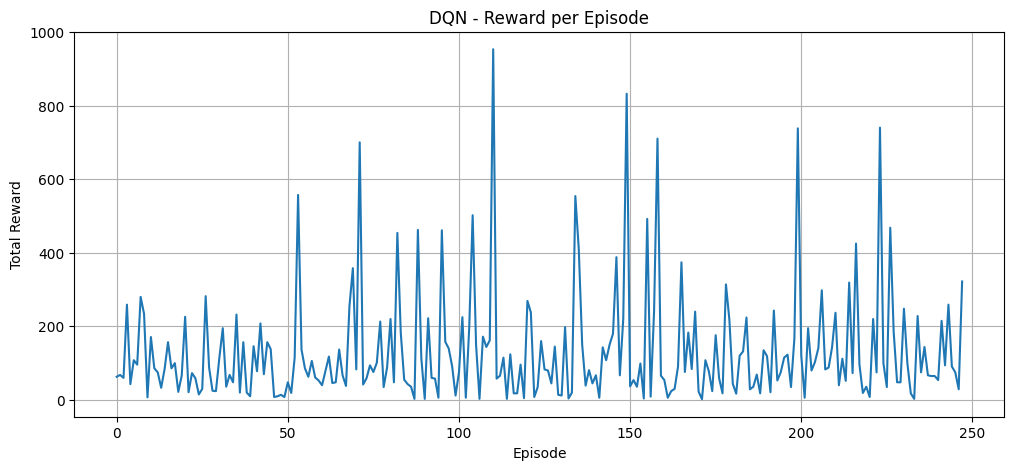

In [54]:
model = DQN("MultiInputPolicy", env, verbose=1, device="cpu")
model.learn(total_timesteps=10000)
model.save("models/dqn_citation_recommender_ule")

# ===============================
# Plot Rewards
# ===============================

rewards = env.get_episode_rewards()
plt.figure(figsize=(12, 5))
plt.plot(rewards)
plt.title("DQN - Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()



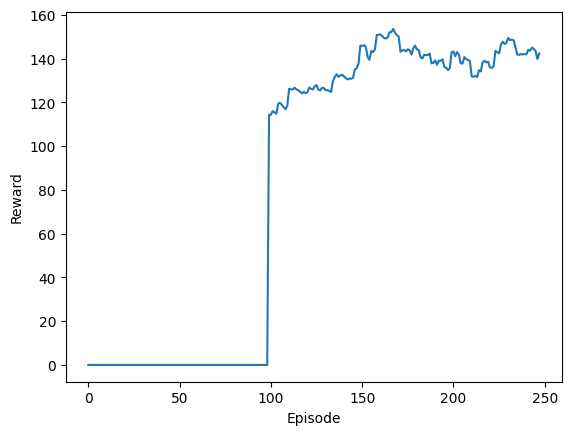

In [ ]:
import torch
def plot_rewards(episode_rewards, window_size=100):
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    if len(rewards_t) >= window_size:
        means = rewards_t.unfold(0, window_size, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(window_size-1), means))
        plt.plot(means.numpy())

plot_rewards(rewards)
